In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
import head_direction.head as head
import spatial_maps as sp
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from distutils.dir_util import copy_tree
from neo import SpikeTrain
import scipy
from functools import reduce
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()


from spike_statistics.core import permutation_resampling_test, block_bootstrap

from spikewaveform.core import calculate_waveform_features_from_template, cluster_waveform_features

from septum_mec.analysis.plotting import violinplot, despine

23:57:00 [I] klustakwik KlustaKwik2 version 0.2.6


## chose where to sample LFP

In [3]:
#################################################

# lfp_location = ''
# lfp_location = '-other-tetrode'
lfp_location = '-other-drive'

##################################################

In [4]:
%matplotlib inline
plt.rc('axes', titlesize=12)
plt.rcParams.update({
    'font.size': 12, 
    'figure.figsize': (6, 4), 
    'figure.dpi': 150
})

output_path = pathlib.Path("output") / ("stimulus-spike-lfp-response" + lfp_location)
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)
output_path.mkdir(exist_ok=True)

In [5]:
data_loader = dp.Data()
actions = data_loader.actions
project = data_loader.project

In [6]:
identification_action = actions['identify-neurons']
sessions = pd.read_csv(identification_action.data_path('sessions'))
units = pd.read_csv(identification_action.data_path('units'))
session_units = pd.merge(sessions, units, on='action')

In [7]:
lfp_action = actions['stimulus-spike-lfp-response' + lfp_location]
lfp_results = pd.read_csv(lfp_action.data_path('results'))

In [8]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
lfp_results = lfp_results.drop('unit_id', axis=1)

In [9]:
stim_action = actions['stimulus-response']
stim_results = pd.read_csv(stim_action.data_path('results'))

In [10]:
# lfp_results has old unit id's but correct on (action, unit_name, channel_group)
# stim_results = stim_results.drop('unit_id', axis=1)

In [11]:
statistics_action = actions['calculate-statistics']
shuffling = actions['shuffling']

statistics_results = pd.read_csv(statistics_action.data_path('results'))
statistics_results = session_units.merge(statistics_results, how='left')
quantiles_95 = pd.read_csv(shuffling.data_path('quantiles_95'))
action_columns = ['action', 'channel_group', 'unit_name']
data = pd.merge(statistics_results, quantiles_95, on=action_columns, suffixes=("", "_threshold"))

In [12]:
data['unit_day'] = data.apply(lambda x: str(x.unit_idnum) + '_' + x.action.split('-')[1], axis=1)

In [13]:
data = data.merge(lfp_results, how='left')

In [14]:
data = data.merge(stim_results, how='left')

In [15]:
waveform_action = actions['waveform-analysis']
waveform_results = pd.read_csv(waveform_action.data_path('results')).drop('template', axis=1)

In [16]:
data = data.merge(waveform_results, how='left')

In [17]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [18]:
data.bs = data.bs.astype(bool)

In [19]:
data.loc[data.eval('t_i_peak == t_i_peak and not bs'), 'ns_inhibited'] = True
data.ns_inhibited.fillna(False, inplace=True)

data.loc[data.eval('t_i_peak != t_i_peak and not bs'), 'ns_not_inhibited'] = True
data.ns_not_inhibited.fillna(False, inplace=True)

In [20]:
# make baseline for inhibited vs not inhibited
data.loc[data.unit_id.isin(data.query('ns_inhibited').unit_id.values), 'ns_inhibited'] = True
data.loc[data.unit_id.isin(data.query('ns_not_inhibited').unit_id.values), 'ns_not_inhibited'] = True

In [21]:
query = (
    'gridness > gridness_threshold and '
    'information_rate > information_rate_threshold and '
    'gridness > .2 and '
    'average_rate < 25'
)
sessions_above_threshold = data.query(query)
print("Number of sessions above threshold", len(sessions_above_threshold))
print("Number of animals", len(sessions_above_threshold.groupby(['entity'])))

Number of sessions above threshold 194
Number of animals 4


In [22]:
gridcell_sessions = data[data.unit_day.isin(sessions_above_threshold.unit_day.values)]
print("Number of gridcells", gridcell_sessions.unit_idnum.nunique())
print("Number of gridcell recordings", len(gridcell_sessions))
print("Number of animals", len(gridcell_sessions.groupby(['entity'])))

Number of gridcells 139
Number of gridcell recordings 230
Number of animals 4


In [23]:
gridcell_sessions

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,t_i_peak,p_i_peak,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited
14,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0087,0.000055,0.259757,0.362390,0.180529,False,0.0,NaN,True,False
21,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0008,0.000880,0.242524,0.534827,2.265039,True,1.0,NaN,False,False
29,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.279806,0.598967,10.924422,True,1.0,NaN,False,False
30,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,0.0005,0.002365,0.265158,0.581451,3.984881,True,1.0,NaN,False,False
31,1839-120619-4,False,1839,30.0,False,True,4,ms,True,stim ii,...,NaN,NaN,0.246920,0.570844,3.497452,True,1.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1263,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.280033,0.560729,4.760330,True,1.0,NaN,False,False
1264,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.281934,0.627089,15.890929,True,1.0,NaN,False,False
1268,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.266512,0.594033,2.704037,True,1.0,NaN,False,False
1271,1833-010719-2,False,1833,11.0,True,False,2,ms,True,stim i,...,NaN,NaN,0.223261,0.592553,9.658453,True,1.0,NaN,False,False


In [24]:
data.loc[:,'gridcell'] = np.nan
data['gridcell'] = data.isin(gridcell_sessions)

data.loc[data.eval('not gridcell and bs'), 'bs_not_gridcell'] = True
data.bs_not_gridcell.fillna(False, inplace=True)

In [25]:
data.query('baseline and Hz11 and gridcell').head()

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag,...,half_width,peak_to_trough,average_firing_rate,bs,bs_stim,bs_ctrl,ns_inhibited,ns_not_inhibited,gridcell,bs_not_gridcell
33,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.272875,0.602667,5.945508,True,NaN,1.0,False,False,True,False
34,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.226452,0.274814,2.860048,False,NaN,0.0,False,True,True,False
35,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.247266,0.570104,3.365674,True,NaN,1.0,False,False,True,False
39,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.284542,0.644111,17.471520,True,NaN,1.0,False,False,True,False
40,1833-260619-1,True,1833,NaN,True,False,1,NaN,False,baseline i,...,0.259920,0.581698,5.891739,True,NaN,1.0,False,False,True,False


In [26]:
keys = [
    'theta_energy',
    'theta_peak',
    'theta_freq',
    'theta_half_width',
    'theta_vec_len',
    'theta_ang',
    'stim_energy',
    'stim_half_width',
    'stim_p_max',
    'stim_strength',
    'stim_vec_len',
    'stim_ang'
]
cell_types = [
    'gridcell', 
    'ns_inhibited', 
    'ns_not_inhibited'
]
results = {}
for cell_type in cell_types:
    results[cell_type] = {}
    for key in keys:
        results[cell_type][key] = list()
        for query, label in zip(queries, labels):
            values = data.query(query + ' and ' + cell_type).loc[:,['entity', 'unit_idnum', 'date', key]]
            results[cell_type][key].append(values.rename({key: label}, axis=1))
            
for cell_type, cell_type_val in results.items():
    for key, val in cell_type_val.items():
        df = reduce(lambda  left, right: pd.merge(left, right, on=['entity', 'unit_idnum', 'date'], how='outer'), val)
        results[cell_type][key] = df#.drop('unit_day',axis=1)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [27]:
def drop_duplicates_least_null(df, key):
    return df.loc[df.notnull().sum(1).groupby(df[key]).idxmax()]

In [28]:
for cell_type, val in results.items():
    for key, df in val.items():
        results[cell_type][key] = drop_duplicates_least_null(df, 'unit_idnum')

In [29]:
results['gridcell']['theta_peak']

,entity,unit_idnum,date,Baseline I,11 Hz,Baseline II,30 Hz
51,1833,8,20719,0.214949,NaN,NaN,NaN
86,1833,13,20719,NaN,0.052683,0.291401,0.055222
87,1833,14,20719,NaN,0.025182,0.451846,NaN
58,1833,23,200619,0.233113,NaN,NaN,NaN
128,1833,26,200619,NaN,NaN,0.202562,0.049574
...,...,...,...,...,...,...,...
140,1849,835,150319,NaN,NaN,NaN,0.027863
43,1849,851,60319,0.040082,NaN,NaN,NaN
65,1849,932,280219,0.025449,NaN,NaN,NaN
74,1849,937,280219,NaN,0.135503,NaN,NaN


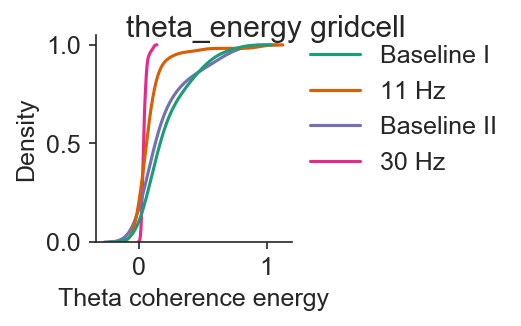

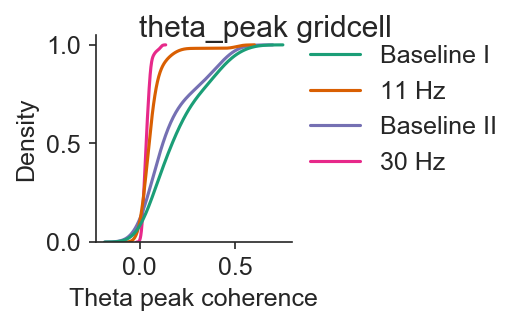

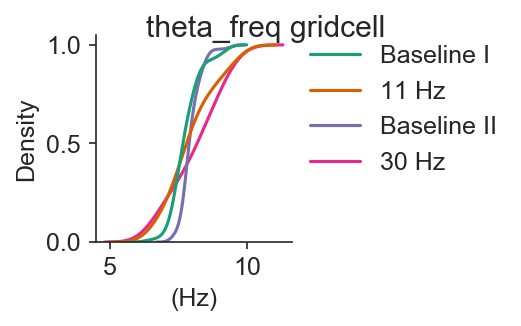

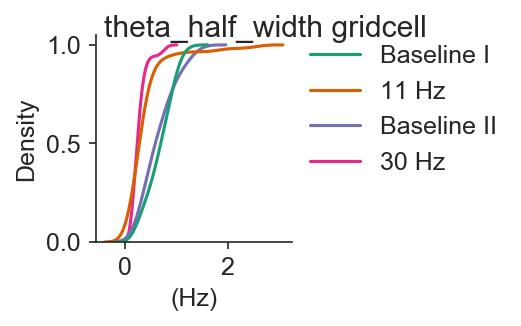

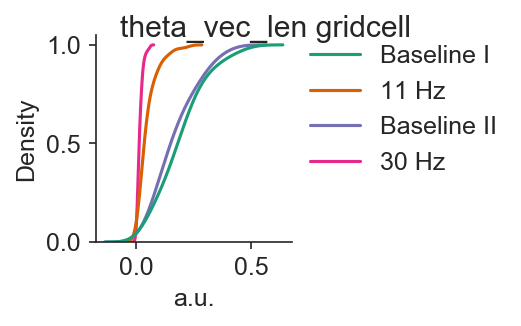

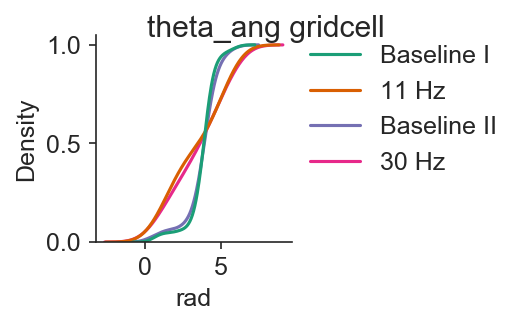

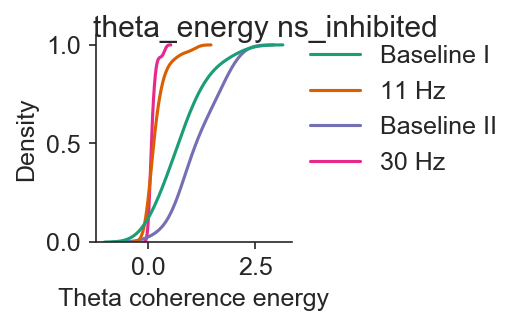

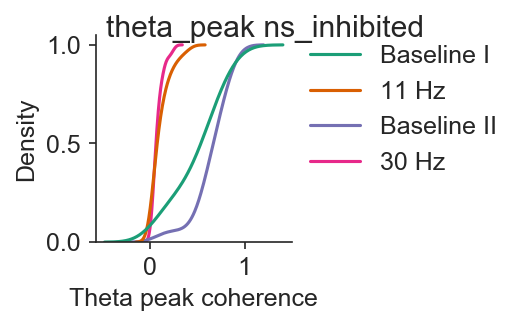

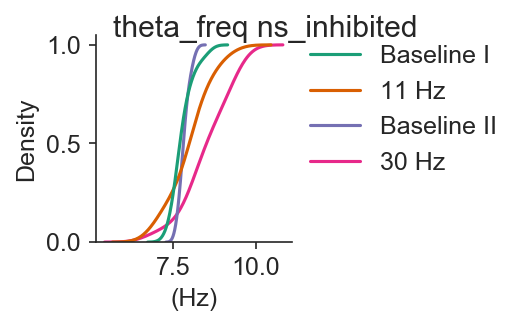

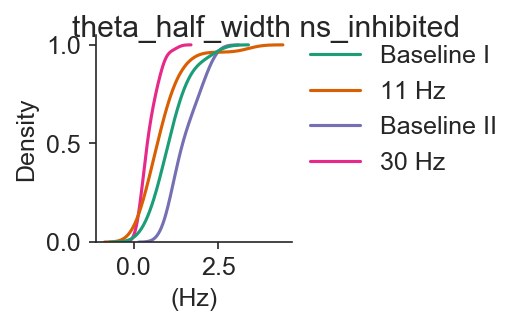

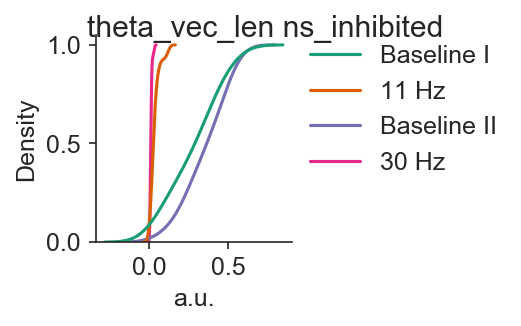

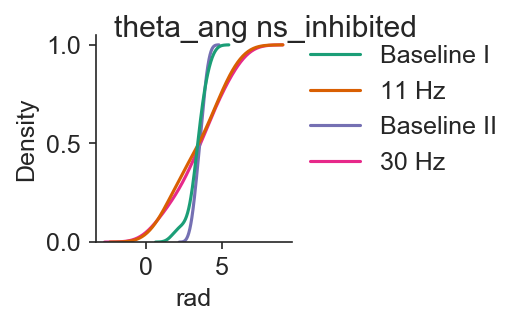

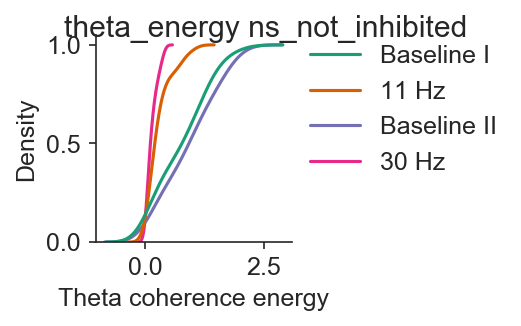

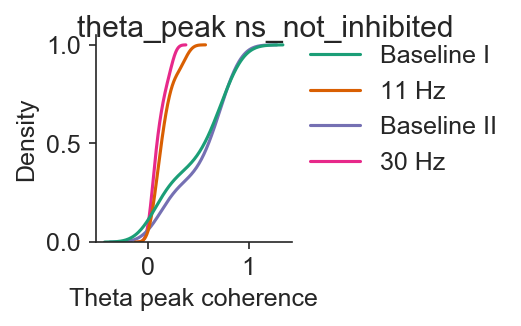

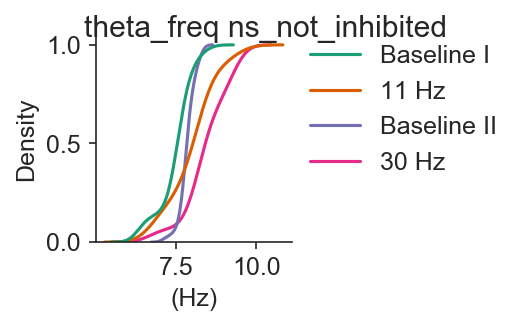

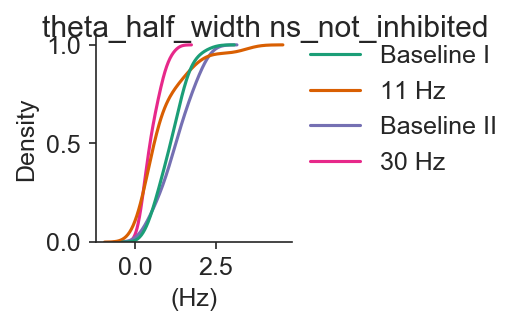

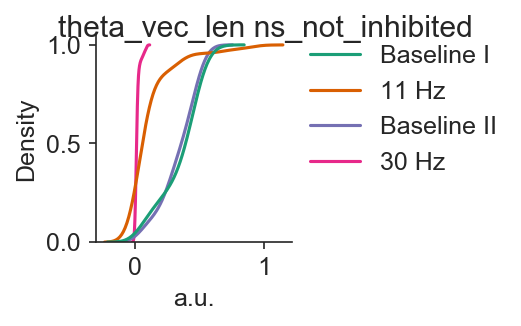

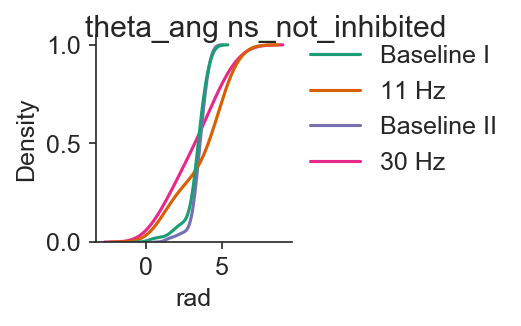

In [30]:
xlabel = {
    'theta_energy': 'Theta coherence energy',
    'theta_peak': 'Theta peak coherence',
    'theta_freq': '(Hz)',
    'theta_half_width': '(Hz)',
    'theta_vec_len': 'a.u.',
    'theta_ang': 'rad'
}
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.7,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors, labels):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels], cumulative=True, legend=False, palette=colors, common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

In [31]:
data['stim_strength'] = data.stim_p_max / data.theta_peak

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


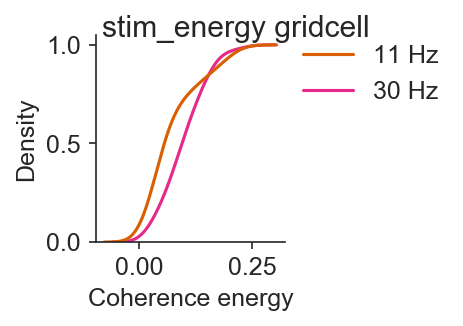

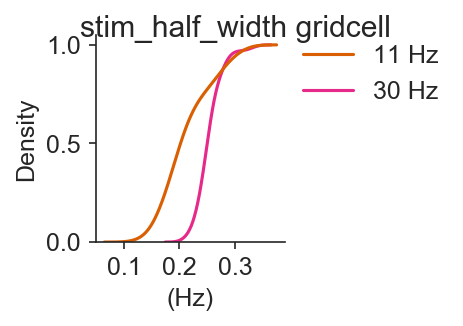

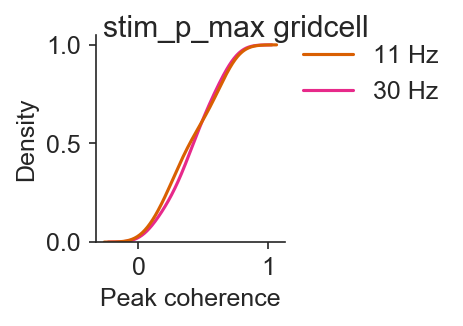

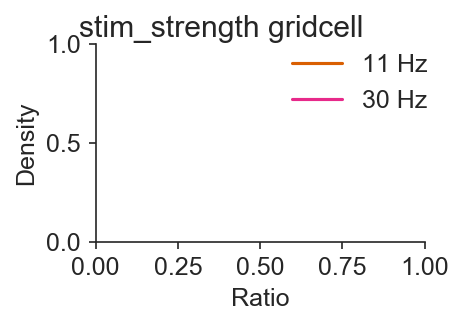

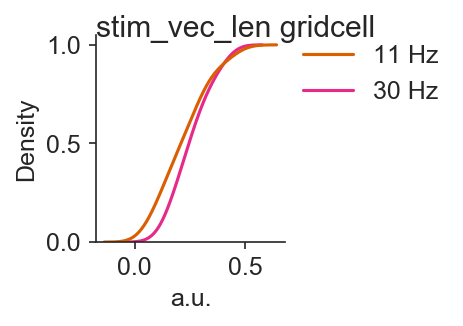

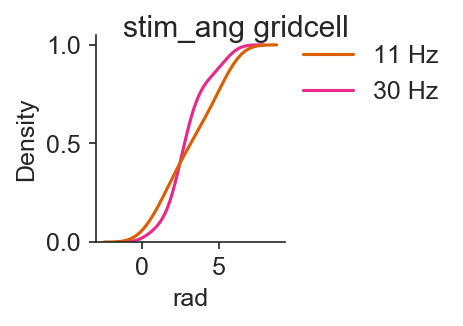

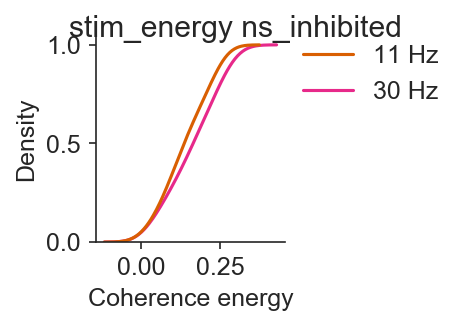

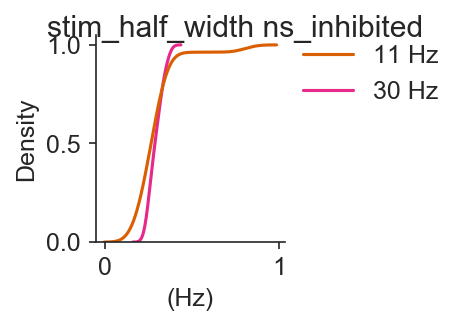

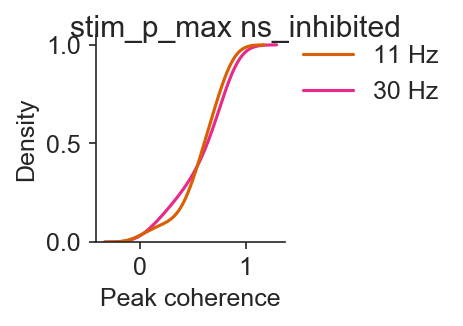

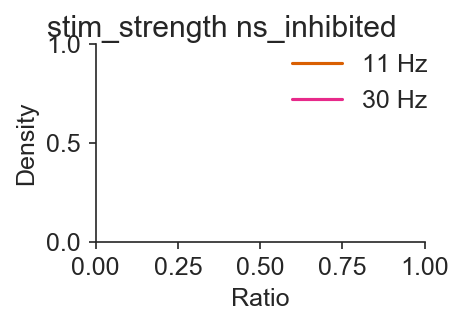

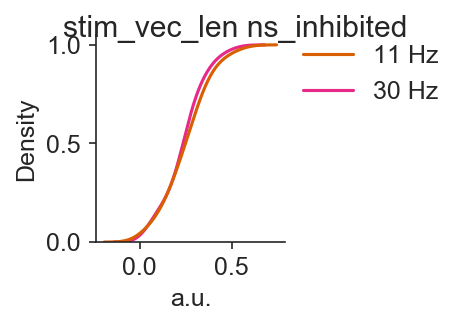

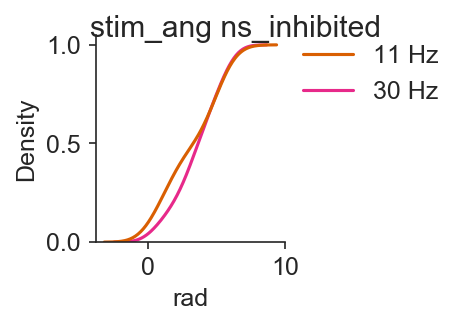

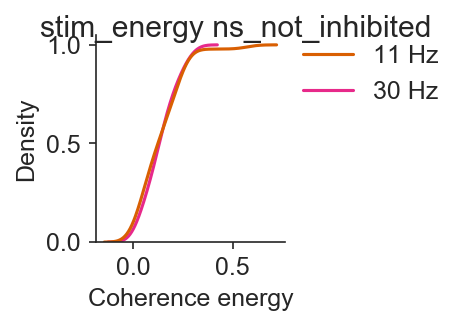

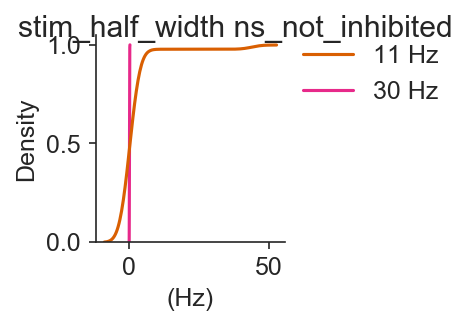

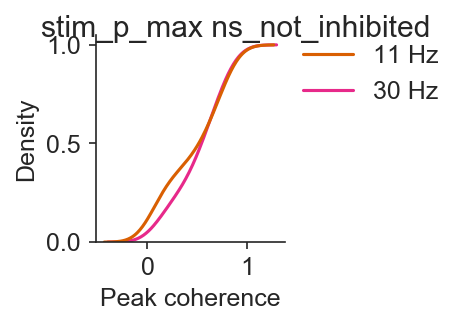

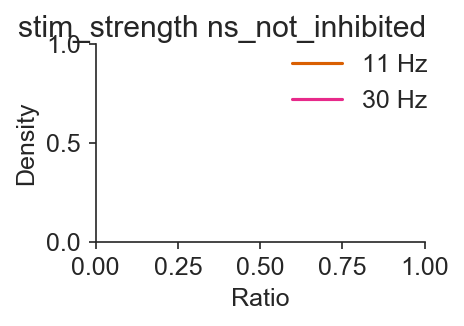

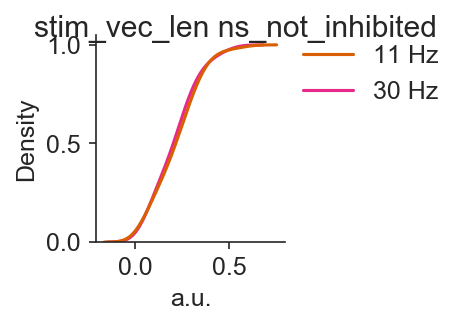

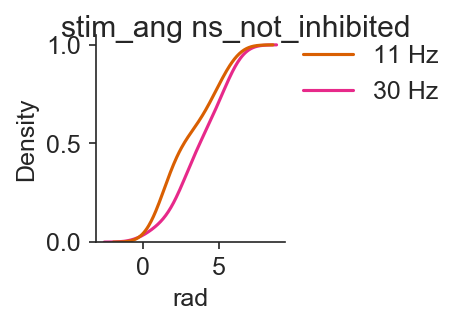

In [32]:
xlabel = {
    'stim_energy': 'Coherence energy',
    'stim_half_width': '(Hz)',
    'stim_p_max': 'Peak coherence',
    'stim_strength': 'Ratio',
    'stim_vec_len': 'a.u.',
    'stim_ang': 'rad'
}
# key = 'theta_energy'
# key = 'theta_peak'
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    for key in xlabel:
        fig = plt.figure(figsize=(3.3,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, label in zip(colors[1::2], labels[1::2]):
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, label=label))
        sns.kdeplot(data=results[cell_type][key].loc[:,labels[1::2]], cumulative=True, legend=False, palette=colors[1::2], common_norm=False)
        plt.xlabel(xlabel[key])
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
        plt.grid(False)
        despine()
        figname = f'spike-lfp-coherence-histogram-{key}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

## polar plot

In [33]:
from septum_mec.analysis.statistics import VonMisesKDE

/home/mikkel/apps/expipe-project/septum-mec/septum_mec/analysis/statistics.py:41: RuntimeWarning: invalid value encountered in greater
  data[data > np.pi] = data[data > np.pi] - np.pi * 2
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


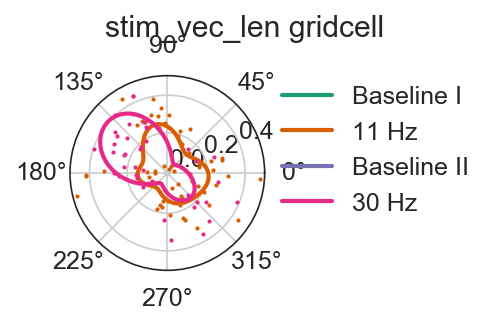

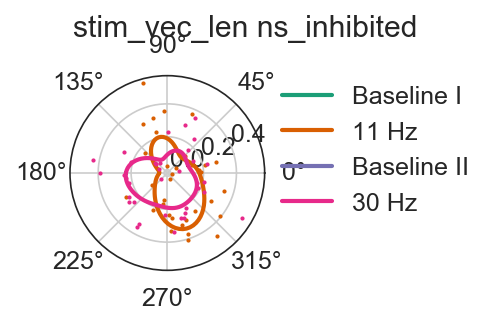

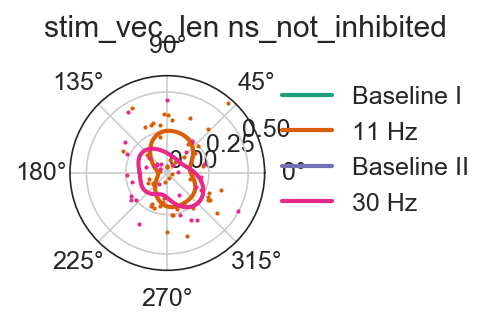

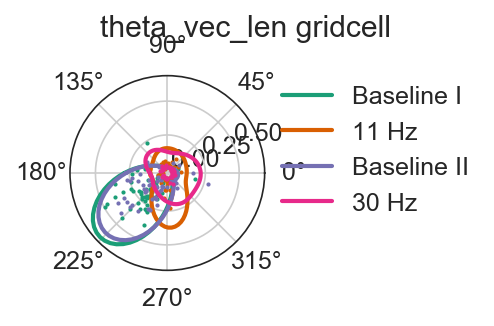

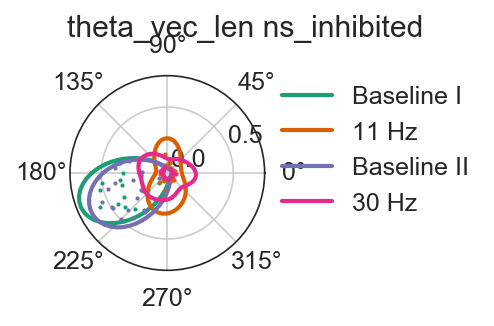

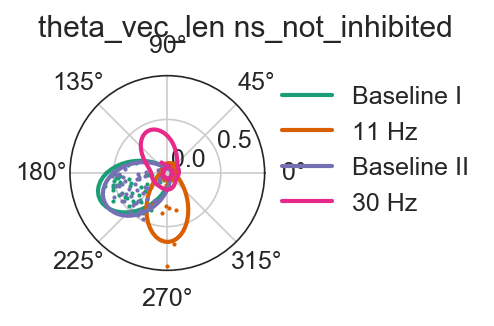

In [34]:
for paradigm in ['stim', 'theta']:
    key = paradigm + '_vec_len'
    for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
        fig = plt.figure(figsize=(3.2,2.2))
        plt.suptitle(key + ' ' + cell_type)
        legend_lines = []
        for color, query, label in zip(colors, queries, labels):
            data_query = data.query(query + ' and ' + cell_type)
            values = data_query[key].values
            angles = data_query[paradigm + '_ang'].values
            kde = VonMisesKDE(angles, weights=values, kappa=5)
            bins = np.linspace(-np.pi, np.pi, 100)
            plt.polar(bins, kde.evaluate(bins), color=color, lw=2)
            plt.polar(angles, values, color=color, lw=1, ls='none', marker='.', markersize=2)
#             values.hist(
#                 bins=bins[key], density=density, cumulative=cumulative, lw=lw, 
#                 histtype=histtype, color=color)
            legend_lines.append(matplotlib.lines.Line2D([0], [0], color=color, lw=2, label=label))
        plt.legend(
            handles=legend_lines,
            bbox_to_anchor=(1.04,1), borderaxespad=0, frameon=False)
        plt.tight_layout()
#         plt.grid(False)
        figname = f'spike-lfp-polar-plot-{paradigm}-{cell_type}'.replace(' ', '-')
        fig.savefig(
            output_path / 'figures' / f'{figname}.png', 
            bbox_inches='tight', transparent=True)
        fig.savefig(
            output_path / 'figures' / f'{figname}.svg', 
            bbox_inches='tight', transparent=True)

# bootstrap stats

In [35]:
bootstrap_results = {}
for cell_type in results:
    bootstrap_results[cell_type] = {}
    for key, df in results[cell_type].items():
        bootstrap_results[cell_type][key] = pd.DataFrame()
        group = df.groupby('entity')
        for label in labels:
            entity_values = np.array([d.loc[:, label].dropna().values for _, d in group if d.loc[:, label].count() > 0])
            if len([i for j in entity_values for i in j]) < 3: # less than total 3 samples
                boot_samples = np.ones(100) * np.nan
            else:
                boot_samples = block_bootstrap(entity_values, n_boots=100, n_samples=10, n_blocks=4, statistic=np.mean)
            bootstrap_results[cell_type][key].loc[:, label] = np.ravel(boot_samples)

In [36]:
bootstrap_results['gridcell']['theta_energy']

,Baseline I,11 Hz,Baseline II,30 Hz
0,0.324016,0.127997,0.457272,0.047980
1,0.386516,0.207346,0.450573,0.036929
2,0.249469,0.081925,0.342295,0.041069
3,0.145502,0.153652,0.125314,0.034900
4,0.393182,0.157994,0.310612,0.038389
...,...,...,...,...
95,0.184705,0.137819,0.424293,0.049197
96,0.276722,0.111610,0.513313,0.049526
97,0.121644,0.118300,0.357199,0.045702
98,0.308533,0.144430,0.270069,0.035213


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3309e4b908>,
      dtype=object)

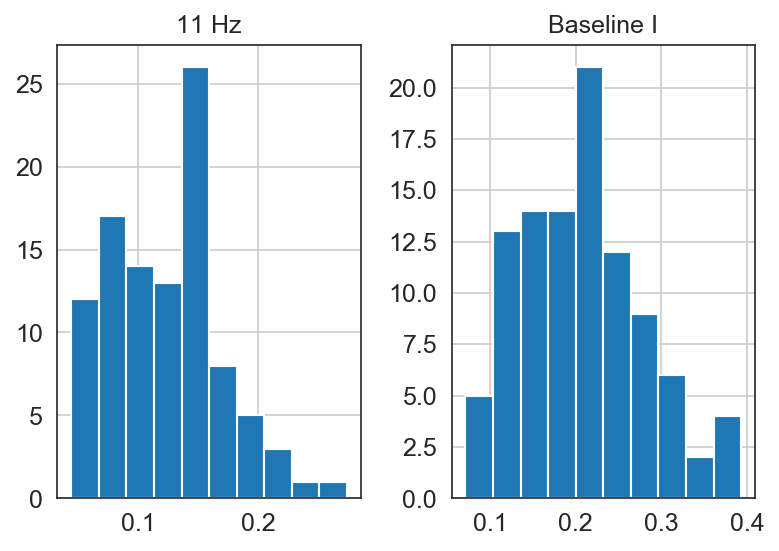

In [37]:
bootstrap_results['gridcell']['theta_energy'].loc[:,['Baseline I', '11 Hz']].hist()

In [38]:
def compute_weighted_mean_sem(data, label):
    group = data.groupby('entity')
    tmp = [d.loc[:, label].dropna().values for _, d in group]
    values = np.concatenate(tmp)
    if len(values) == 0:
        return [np.nan] * 3
    weights = np.concatenate([np.ones_like(a) / len(a) for a in tmp])
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average)**2, weights=weights)
    sem = np.sqrt(variance / len(values))
    return average, sem, len(values)


def compute_confidence_interval(data, alpha=0.05):
    stat = np.sort(data.dropna())
    n = len(stat)
    if n == 0:
        return np.nan, np.nan
    low = stat[int((alpha / 2.0) * n)]
    high = stat[int((1 - alpha / 2.0) * n)]
#     low, high = np.percentile(data.dropna(), [(alpha / 2.0) * 100, (1 - alpha / 2.0) * 100])
    return low, high


def pvalue(df, df_bootstrap, control_key, case_key):
    '''
    pvalue
    '''
    case, b = df_bootstrap[case_key].dropna(), df_bootstrap[control_key].dropna()
    if len(case) == 0 or len(b) == 0:
        return np.nan
    
    n = len(case)
    
    average_case, _, _ = compute_weighted_mean_sem(df, case_key)
    average_control, _, _ = compute_weighted_mean_sem(df, control_key)
    
    low, high = compute_confidence_interval(average_control - case)
    
    case_shift = case - case.mean()
    diff = abs(average_case - average_control)    
    
    pval = (np.sum(case_shift > diff) + np.sum(case_shift < - diff)) / n
    
    return "{:.1e} [{:.2f}, {:.2f}]".format(pval, low, high)


def rename(name):
    return name.replace("_field", "-field").replace("_", " ").capitalize()

In [39]:
stats = {}
for cell_type in bootstrap_results:
    stat = pd.DataFrame()

    for key, df in bootstrap_results[cell_type].items():
        Key = rename(key)
        
        for label in labels:
#             low, high = compute_confidence_interval(df.loc[:,label])
#             average, _, n = compute_weighted_mean_sem(results[cell_type][key], label)
#             stat.loc[label, Key] = "{:.2f} [{:.2f}, {:.2f}] ({})".format(average, low, high, n)
            average, sem, n = compute_weighted_mean_sem(results[cell_type][key], label)
            if np.isnan(average):
                stat.loc[label, Key] = np.nan
            else:
                stat.loc[label, Key] = "{:.2f} ± {:.2f} ({})".format(average, sem, n)

        for i, c1 in enumerate(df.columns):
            for c2 in df.columns[i+1:]:
                stat.loc[f'{c1} - {c2}', Key] = pvalue(results[cell_type][key], df, c1, c2)

    stats[cell_type] = stat

In [40]:
stats['gridcell']

,Theta energy,Theta peak,Theta freq,Theta half width,Theta vec len,Theta ang,Stim energy,Stim half width,Stim p max,Stim strength,Stim vec len,Stim ang
Baseline I,0.20 ± 0.03 (63),0.17 ± 0.02 (63),7.74 ± 0.08 (63),0.64 ± 0.04 (63),0.20 ± 0.01 (63),3.73 ± 0.10 (63),NaN,NaN,NaN,NaN,NaN,NaN
11 Hz,0.12 ± 0.02 (57),0.08 ± 0.01 (57),7.79 ± 0.13 (57),0.47 ± 0.08 (57),0.04 ± 0.00 (57),3.27 ± 0.26 (57),0.09 ± 0.01 (59),0.22 ± 0.01 (59),0.44 ± 0.03 (59),NaN,0.22 ± 0.02 (59),2.91 ± 0.26 (59)
Baseline II,0.33 ± 0.04 (46),0.25 ± 0.03 (46),8.11 ± 0.04 (46),0.82 ± 0.06 (46),0.23 ± 0.02 (46),3.96 ± 0.11 (46),NaN,NaN,NaN,NaN,NaN,NaN
30 Hz,0.04 ± 0.00 (35),0.04 ± 0.00 (35),7.93 ± 0.20 (35),0.30 ± 0.03 (35),0.02 ± 0.00 (35),3.81 ± 0.31 (35),0.09 ± 0.01 (33),0.25 ± 0.00 (33),0.39 ± 0.03 (33),NaN,0.25 ± 0.01 (33),2.60 ± 0.24 (33)
Baseline I - 11 Hz,"5.0e-02 [-0.02, 0.15]","0.0e+00 [0.04, 0.12]","8.8e-01 [-0.73, 0.52]","3.4e-01 [-0.23, 0.39]","0.0e+00 [0.14, 0.17]","1.9e-01 [-0.35, 1.10]",NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - Baseline II,"3.3e-01 [-0.33, 0.09]","3.3e-01 [-0.20, 0.05]","0.0e+00 [-0.57, -0.20]","2.2e-01 [-0.52, 0.06]","6.2e-01 [-0.14, 0.07]","3.3e-01 [-0.70, 0.13]",NaN,NaN,NaN,NaN,NaN,NaN
Baseline I - 30 Hz,"0.0e+00 [0.14, 0.17]","0.0e+00 [0.11, 0.14]","5.5e-01 [-0.67, 0.41]","0.0e+00 [0.25, 0.42]","0.0e+00 [0.17, 0.18]","8.5e-01 [-0.60, 0.62]",NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - Baseline II,"5.0e-02 [-0.41, 0.01]","1.0e-02 [-0.29, -0.04]","0.0e+00 [-0.52, -0.15]","2.0e-02 [-0.69, -0.11]","0.0e+00 [-0.29, -0.09]","0.0e+00 [-1.16, -0.33]",NaN,NaN,NaN,NaN,NaN,NaN
11 Hz - 30 Hz,"0.0e+00 [0.06, 0.09]","0.0e+00 [0.02, 0.05]","7.2e-01 [-0.62, 0.45]","0.0e+00 [0.08, 0.25]","0.0e+00 [0.02, 0.03]","8.0e-02 [-1.06, 0.16]","7.8e-01 [-0.03, 0.02]","0.0e+00 [-0.04, -0.02]","4.1e-01 [-0.04, 0.15]",NaN,"2.8e-01 [-0.08, 0.02]","5.1e-01 [-0.47, 1.08]"
Baseline II - 30 Hz,"0.0e+00 [0.28, 0.30]","0.0e+00 [0.19, 0.21]","5.5e-01 [-0.30, 0.78]","0.0e+00 [0.44, 0.60]","0.0e+00 [0.20, 0.21]","6.8e-01 [-0.37, 0.85]",NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
for cell_type, stat in stats.items():
    stat.to_latex(output_path / "statistics" / f"statistics_{cell_type}.tex")
    stat.to_csv(output_path / "statistics" / f"statistics_{cell_type}.csv")

# paired stats

In [42]:
def wilcoxon(df, keys):
    dff = df.loc[:,[keys[0], keys[1]]].dropna()
    statistic, pvalue = scipy.stats.wilcoxon(
        dff[keys[0]], 
        dff[keys[1]],
        alternative='two-sided')

#     return "{:.2f}, {:.2f}, {:.2f}, {:.1e}, ({})".format(dff[keys[0]].mean(), dff[keys[1]].mean(), statistic, pvalue, len(dff))
    return "{:.2f}, {:.1e}, ({})".format(statistic, pvalue, len(dff))
#     return pvalue

def MWU(df, keys):
    '''
    Mann Whitney U
    '''
    d1 = df[keys[0]].dropna()
    d2 = df[keys[1]].dropna()
    Uvalue, pvalue = scipy.stats.mannwhitneyu(
        d1, d2, alternative='two-sided')

#     return"{:.2f}, {:.2f}, {:.0f}, {:.1e}, ({}), ({})".format(d1.mean(), d2.mean(), Uvalue, pvalue, len(d1), len(d2))
#     return"{:.0f}, {:.1e}".format(Uvalue, pvalue)
    return pvalue

    
def normality(df, key):
    statistic, pvalue = scipy.stats.normaltest(
        df[key].dropna())

    return "{:.2f}, {:.1e}".format(statistic, pvalue)

In [43]:
paired_stats = {}
for cell_type, cell_results in results.items():
    paired_stat = pd.DataFrame()

    for key, df in cell_results.items():
        Key = rename(key)
        
        for label in labels:
            norm = normality(df, label) if df[label].count() >= 8 else np.nan
            paired_stat.loc[f'Normality {label}', Key] = norm

        for i, c1 in enumerate(labels):
            for c2 in labels[i+1:]:
    #             paired_stat.loc[f'{c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                try:
                    paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = wilcoxon(df, [c1, c2])
                except:
                    paired_stat.loc[f'Wilcoxon {c1} - {c2}', Key] = np.nan
    #             paired_stat.loc[f'MWU {c1} - {c2}', Key] = MWU(df, [c1, c2])
    paired_stats[cell_type] = paired_stat

paired_stat

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))
/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


,Theta energy,Theta peak,Theta freq,Theta half width,Theta vec len,Theta ang,Stim energy,Stim half width,Stim p max,Stim strength,Stim vec len,Stim ang
Normality Baseline I,"6.36, 4.2e-02","36.87, 9.8e-09","8.20, 1.7e-02","0.85, 6.6e-01","5.46, 6.5e-02","34.27, 3.6e-08",NaN,NaN,NaN,NaN,NaN,NaN
Normality 11 Hz,"19.06, 7.3e-05","7.35, 2.5e-02","0.13, 9.4e-01","30.96, 1.9e-07","53.81, 2.1e-12","8.66, 1.3e-02","23.18, 9.2e-06","105.81, 1.1e-23","49.37, 1.9e-11",NaN,"0.98, 6.1e-01","33.50, 5.3e-08"
Normality Baseline II,"10.45, 5.4e-03","13.02, 1.5e-03","5.68, 5.8e-02","3.60, 1.7e-01","3.69, 1.6e-01","27.63, 1.0e-06",NaN,NaN,NaN,NaN,NaN,NaN
Normality 30 Hz,"4.88, 8.7e-02","4.12, 1.3e-01","3.96, 1.4e-01","2.92, 2.3e-01","38.02, 5.6e-09","3.47, 1.8e-01","1.48, 4.8e-01","3.27, 1.9e-01","2.81, 2.5e-01",NaN,"1.31, 5.2e-01","1.75, 4.2e-01"
Wilcoxon Baseline I - 11 Hz,"4.00, 2.3e-03, (14)","3.00, 1.9e-03, (14)","19.00, 3.5e-02, (14)","48.00, 7.8e-01, (14)","0.00, 9.8e-04, (14)","32.00, 2.0e-01, (14)",NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon Baseline I - Baseline II,"24.00, 4.1e-02, (15)","46.00, 4.3e-01, (15)","14.00, 8.7e-02, (15)","23.00, 3.6e-02, (15)","43.00, 3.3e-01, (15)","59.00, 9.5e-01, (15)",NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon Baseline I - 30 Hz,"0.00, 6.5e-04, (15)","1.00, 8.1e-04, (15)","25.50, 4.9e-02, (15)","3.00, 1.2e-03, (15)","0.00, 6.5e-04, (15)","58.00, 9.1e-01, (15)",NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon 11 Hz - Baseline II,"0.00, 2.9e-04, (17)","0.00, 2.9e-04, (17)","48.00, 4.9e-01, (17)","39.00, 7.6e-02, (17)","0.00, 2.9e-04, (17)","61.00, 4.6e-01, (17)",NaN,NaN,NaN,NaN,NaN,NaN
Wilcoxon 11 Hz - 30 Hz,"7.00, 2.1e-02, (11)","11.00, 5.0e-02, (11)","17.00, 2.8e-01, (11)","7.00, 2.1e-02, (11)","0.00, 3.3e-03, (11)","23.00, 3.7e-01, (11)","5.00, 1.3e-02, (11)","12.00, 6.2e-02, (11)","6.00, 1.6e-02, (11)",NaN,"12.00, 6.2e-02, (11)","20.00, 2.5e-01, (11)"
Wilcoxon Baseline II - 30 Hz,"0.00, 4.0e-05, (22)","0.00, 4.0e-05, (22)","23.00, 7.6e-04, (22)","1.00, 4.6e-05, (22)","0.00, 4.0e-05, (22)","106.00, 5.1e-01, (22)",NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
for cell_type, paired_stat in paired_stats.items():
    paired_stat.to_latex(output_path / "statistics" / f"paired-statistics_{cell_type}.tex")
    paired_stat.to_csv(output_path / "statistics" / f"paired-statistics_{cell_type}.csv")

In [45]:
for cell_type, cell_results in results.items():
    for key, result in cell_results.items():
        result.to_latex(output_path / "statistics" / f"values_{cell_type}_{key}.tex")
        result.to_csv(output_path / "statistics" / f"values_{cell_type}_{key}.csv")

# psd plots

In [46]:
from septum_mec.analysis.plotting import plot_bootstrap_timeseries

In [47]:
coher = pd.read_feather(output_path / 'data' / 'coherence.feather')
freqs = pd.read_feather(output_path / 'data' / 'freqs.feather')

In [48]:
freq = freqs.T.iloc[0].values

mask = (freq < 100)

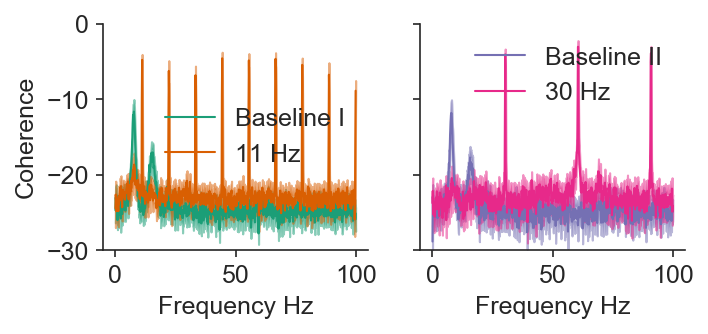

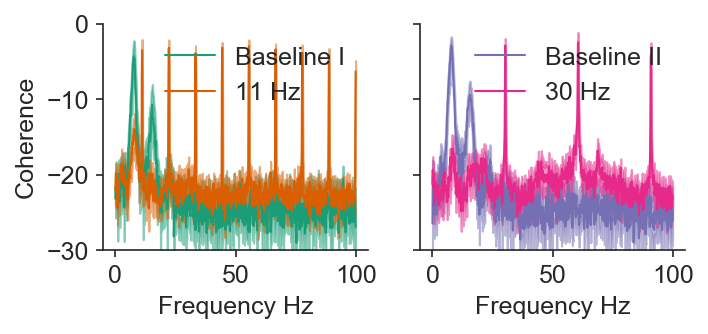

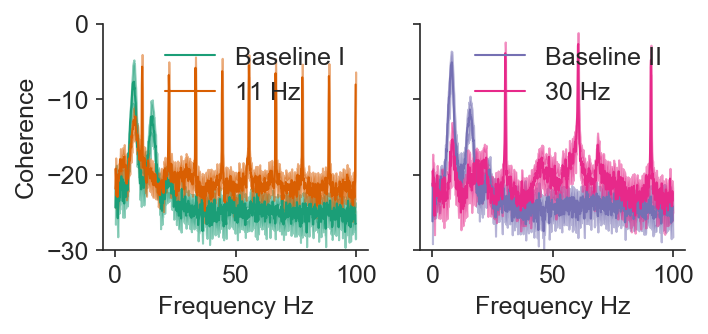

In [49]:
for cell_type in ['gridcell', 'ns_inhibited', 'ns_not_inhibited']:
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(5,2))
    axs = axs.repeat(2)
    for i, (ax, query) in enumerate(zip(axs.ravel(), queries)):
        selection = [
            f'{r.action}_{r.channel_group}_{r.unit_name}' 
            for i, r in data.query(query + ' and ' + cell_type).iterrows()]
        values = coher.loc[mask, selection].dropna(axis=1).to_numpy()
        values = 10 * np.log10(values)
        plot_bootstrap_timeseries(freq[mask], values, ax=ax, lw=1, label=labels[i], color=colors[i])
    #     ax.set_title(titles[i])
        ax.set_xlabel('Frequency Hz')
        ax.legend(frameon=False)
        ax.set_ylim(-30, 0)
    axs[0].set_ylabel('Coherence')
    despine()
    figname = f'spike-lfp-coherence-{cell_type}'.replace(' ', '-')
    fig.savefig(
        output_path / 'figures' / f'{figname}.png', 
        bbox_inches='tight', transparent=True)
    fig.savefig(
        output_path / 'figures' / f'{figname}.svg', 
        bbox_inches='tight', transparent=True)

# Store results in Expipe action

In [50]:
action = project.require_action("stimulus-spike-lfp-response" + lfp_location)

In [51]:
copy_tree(output_path, str(action.data_path()))

['/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/values_gridcell_theta_freq.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/values_gridcell_theta_freq.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/paired-statistics_ns_not_inhibited.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/values_ns_not_inhibited_theta_energy.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/values_ns_inhibited_theta_half_width.csv',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/paired-statistics_gridcell.tex',
 '/media/storage/expipe/septum-mec/actions/stimulus-spike-lfp-response-other-drive/data/statistics/values_ns_inhibited_theta_ang.csv',
 '/media/storage/expipe/septum-mec/actions/st

In [52]:
septum_mec.analysis.registration.store_notebook(action, "20_stimulus-spike-lfp-response.ipynb")